# Risikobasierte Faktoren: Total Risk

## Hintergrund und Motivation

Klassische ("rationale") Finance-Theory (z.B. das CAPM) besagt, dass in einem effizienten Markt riskantere Aktien mit höherem erwarteten Risiko auch höhere erwartete Renditen versprechen sollten um Investoren für das größere Risiko zu kompensieren. Es gibt aber signifikante empirische Evidenz die diesen fundamentalen positiven Risiko-Rendite Zusammenhang in Frage stellt. Das empirische Phänomen in dem risikoarme (d.h., Low Risk) Aktien eine höhere Kompensation pro Einheit Risiko (das sogenannte *Alpha*) versprechen als riskante (d.h., High Risk) Aktien wird als die **Low Risk Anomalie (LRA)** bezeichnet. Ang (2014) und Baker, Bradley und Wurgler (2011) geben eine sehr lesenswerte Einführung in die empirische Signifikanz und in potentielle Erklärungen zur Existenz der LRA. Es kann dabei gründsätzlich zwischen den folgenden Erklärungsansätzen unterschieden werden: 

1. Lotterie-Präferenzen irrationaler Investoren kombiniert mit Arbitragebeschränkungen

Auf Basis der kumulativen Prospekttheorie (Barberis und Huang, 2008) wird argumentiert, dass insbesondere individuelle ("Retail") Anleger kleine Chancen auf große Gewinne übergewichten. Sie besitzen demnach Lotteriepräferenzen. Infolgedessen bevorzugen sie Aktien mit positiver Schiefe (Skewness) in der Renditeverteilung. Diese Aktien sind dann aufgrund der erhöhten Nachfrage bei gegebenem Angebot überbewertet, was zu geringeren zukünftigen Renditen führt. Sind Aktienkursrisiko und Schiefe der Renditeverteilung positiv miteinander korreliert, können Lotteriepräferenzen die LRA erklären. Arbitragebeschränkungen in Form von Benchmarking und der Verzicht auf den Einsatz von Fremdkapital (siehe hierzu insbesondere Baker, Bradley und Wurgler, 2011) seitens institutioneller Investoren führen dazu, dass die LRA nicht "arbitriert" wird.

2. Abweichungen vom Ideal eines friktionslosen Marktes (Market Frictions)

Die zweite Gruppe von Erklärungen der LRA basiert auf sogenannten Market Frictions, also Abweichungen vom theoretischen Idealbild eines vollkommenen Marktes. Zu den Friktionen zählen insbesondere Transaktionskosten, Marktmikrostrukturverzerrungen wie der Bid-Ask Bounce oder eine kurzfristige Renditeumkehr (Mean Reversion). 

3. Erklärungen basierend auf Unsicherheit, Variance Beta, Earnings Surprises, etc.


Im folgenden werden wir drei mögliche Wege im Form einer Faktorstrategie implementieren, mit dem Ziel eine potentiell vorhandene LRA auszunutzen. Im Kern geht es darum, High Risk (HR) und Low Risk (LR) Aktien zu identifizieren, und dann Long (Short) in die LR (HR) Aktien zu gehen. Die Strategierendite ergibt sich aus der Renditedifferenz zwischen dem Long und dem Short Portfolio. Wir messen die risikoadjustierte Strategierendite über die annualisierte Sharpe-Ratio. 

Unsere drei risikobasierten Faktorstrategien unterscheiden sich darin, wie wir das Aktienkursrisiko messen. Wir suchen also genau nach dem Risikomaß, das zukunftige Renditen am besten prognostiziert. Im ersten Fall verwenden wir die historische Renditestandardabweichung (*Total Risk*), im Zweiten die historische Standardabweichung der idiosynkratischen Renditen bzw. Renditeresiduen (*Idiosyncratic Volatility*), und schließlich das historische Aktienbeta (*Beta*).  

## Beginn der Fallstudie

In [1]:
import numpy as np
import pandas as pd

Für unsere beispielhafte Implementierung risikobasierter Faktorstrategien zur Ausnutzung der LRA wählen wir als Anlageuniversum die Aktien des S&P500 für einen täglichen Zeitraum vom 3.1.2017 bis zum 14.11.2019. Die Daten sind im File "s&p_500_15112019.csv" enthalten. 

In [2]:
cd "C:\Users\Galina\Documents\Thomas\Python Projekte\examplefiles"

C:\Users\Galina\Documents\Thomas\Python Projekte\examplefiles


In [3]:
# load file from disk
px = pd.read_csv('s&p_500_15112019.csv', 
                   parse_dates=True, index_col=0)
px = px.asfreq('B').fillna(method='pad')

In [4]:
px.head(2)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,36.866280,54.056015,112.360001,110.738106,35.941536,103.480003,11.43,169.755737,10.266887,141.927734,...,118.256813,81.712685,37.324787,25.328613,55.914982,47.835201,60.320660,101.052895,40.778381,52.556099
2017-01-04,37.158947,54.818222,115.739998,111.004356,36.647812,104.139999,11.43,171.148819,10.178833,145.451904,...,119.715340,84.347366,37.490185,26.284410,55.507954,48.548149,60.540157,101.981964,41.363899,53.066067


### Total Risk als Faktor

Lassen Sie uns beginnen und die Aktien des S&P500 an jedem Handelstag anhand ihrer vergangenen rollierenden historischen Renditestandardabweichung in Dezile  sortieren. Zunächst berechnen wir für jeden Tag die diskrete Rendite. Dies geschieht durch `px.pct_change()`. Wir speichern die Renditen im DataFrame `ret` und berechnen über `rolling(window, min_periods).std()` ein neues DataFrame `stdev` mit rollierenden täglichen historischen Renditestandardabweichungen. Wir müssen die Länge für das rollierende Zeitfenster (Argument `window`) und die Mindestanzahl an Renditebeobachtungen (Argument `min_periods`) zur Berechnung der Standardabweichung festlegen. 

### Implementierung 1: gleichgewichtete Dezil-Portfolios

Danach bringen wir die Aktien über die Methode `rank(axis=1, pct=True)` in eine Perzentil-Rankordnung gemäß der vergangenen Renditestandardabweichung. Aus den Perzentilen können wir Dezile generieren indem wir mit 10 multiplizieren (`mul(10)`) und dann auf die nächste ganze Zahl aufrunden (`np.ceil`). Wollen wir Aktien alternativ in Quintile sortieren, multiplizieren wir einfach mit 5 (`mul(5)`). **Wichtig:** durch die Festlegung `ascending=False` werden Aktien mit den höchsten (geringsten) Standardabweichungen in Gruppe 1 (10) sortiert. Äquivalent werden bei `ascending=True` die riskanten Aktien in Gruppe 10 und die risikoarmen Aktien in Gruppe 1 sortiert. 

In [5]:
# calculation of daily returns
ret = px.pct_change().dropna(how='all')
# calculation of std over rolling window
stdev = ret.rolling(window=250, min_periods = 150).std() 
# important: ascending ='False': risky stocks in decile 1; riskless stocks in decile 10!
rank_df = np.ceil(stdev.rank(axis=1, pct=True, ascending=False).mul(10))
rank_df.tail(5)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-08,8.0,4.0,1.0,9.0,2.0,4.0,1.0,5.0,8.0,2.0,...,9.0,1.0,10.0,2.0,1.0,6.0,10.0,7.0,5.0,7.0
2019-11-11,8.0,4.0,1.0,9.0,2.0,4.0,1.0,5.0,8.0,2.0,...,9.0,1.0,10.0,2.0,1.0,6.0,10.0,7.0,5.0,7.0
2019-11-12,8.0,4.0,1.0,9.0,2.0,4.0,1.0,5.0,8.0,2.0,...,9.0,1.0,10.0,2.0,1.0,6.0,10.0,7.0,5.0,7.0
2019-11-13,8.0,4.0,1.0,9.0,2.0,4.0,1.0,5.0,8.0,2.0,...,9.0,1.0,10.0,2.0,1.0,6.0,10.0,7.0,5.0,7.0
2019-11-14,8.0,4.0,1.0,9.0,2.0,4.0,1.0,5.0,8.0,2.0,...,9.0,1.0,10.0,2.0,1.0,6.0,10.0,7.0,5.0,7.0


Wir transformieren das DataFrame `rank_df` nun in ein DataFrame mit Positionsindikatoren: -1 für eine Short Position in Dezil 1 Aktien, 0 für eine Flat (d.h. keine) Position in Aktien der Dezile 2 bis 9, und 1 für eine Long Position in Dezil 10 Aktien. 

**Beachten Sie**: Da wir Long in Dezil 10 und Short in Dezil 1 gehen, implementieren wir durch die Wahl von `ascending=True` eine High-Risk Strategie, und durch `ascending=False` eine Low-Risk Strategie!

In [6]:
for col in rank_df.columns:
    rank_df[col] = np.where(rank_df[col]>9, 1, np.where(rank_df[col]<2, -1, 0))
rank_df.tail(5)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-08,0,0,-1,0,0,0,-1,0,0,0,...,0,-1,1,0,-1,0,1,0,0,0
2019-11-11,0,0,-1,0,0,0,-1,0,0,0,...,0,-1,1,0,-1,0,1,0,0,0
2019-11-12,0,0,-1,0,0,0,-1,0,0,0,...,0,-1,1,0,-1,0,1,0,0,0
2019-11-13,0,0,-1,0,0,0,-1,0,0,0,...,0,-1,1,0,-1,0,1,0,0,0
2019-11-14,0,0,-1,0,0,0,-1,0,0,0,...,0,-1,1,0,-1,0,1,0,0,0


Führen wir nun alles zusammen in der Funktion `weights_dc_equal`. Diese Funktion erfordert als Eingabe ein DataFrame mit Aktienpreisen (*price*), die Angabe des Zeitraums (*window*) für die Berechnung der historischen Renditestandardabweichung als Ranking-Faktor, die Minimum-Anzahl (*min_periods*) an Renditebeobachtungen, und die Anzahl der Tage (*lag*) die bis zur Implementierung der Strategie vergehen (sollen). 

In [38]:
# 'price' = DataFrame with daily stock prices 
def weights_dc_equal(price, window=250, min_periods=50, lag=0):
    # calculation of daily returns
    ret = price.shift(lag).pct_change().dropna(how='all')
    # calculation of std over rolling window
    stdev = ret.rolling(window, min_periods = min_periods).std() 
    # important: ascending ='False': risky stocks in decile 1; riskless stocks in decile 10!
    rank_df = np.ceil(stdev.rank(axis=1, pct=True, ascending=False).mul(10))
    for col in rank_df.columns:
        rank_df[col] = np.where(rank_df[col]>9, 1, np.where(rank_df[col]<2, -1, 0))
    return rank_df

Zudem definieren wir wieder unsere zwei **Lambda** Funktionen:
    
    1. "compound" berechnet aus dem Eingabe-Array x kumulative Mehr-Tagesrenditen;
    2. "daily_sr" berechnet aus einem Array von Tagesrenditen die tägliche Sharpe-Ratio;

In [8]:
# cumulative returns
compound = lambda x: (1 + x).prod() - 1

# daily Sharpe Ratio
daily_sr = lambda x: x.mean() / x.std()

Im folgenden berechnen wir zunächst für jeden Handelstag die nicht-normierten Aktiengewichte (-1: Short; 0: Flat; 1: Long) durch Anwendung unserer Funktion `weights_dc_equal`. Das resultierende DataFrame nennen wir `port`. Dann legen wir die Anzahl der Handelstage (*hold*) fest, für die wir das Portfolio halten wollen ohne die Gewichte umzuschichten. 

Im letzten Schritt reduzieren wir die Zeitfrequenz von `port` auf die Länge (*hold*) der gewählten Portfoliohalteperiode, setzen die Gewichte auf die Werte die zu Beginn der Halteperiode gelten (über `.first()`), und wählen `.shift(1)`, da in t nur die Gewichte die zum Zeitpunkt t-1 bekannt sind implementiert werden können.  

In [10]:
hold = 21
freq = '%dB' % hold # holding period 
port = weights_dc_equal(px) # security weights at business day freq
# calculation of portfolio returns
port = port.shift(1).resample(freq).first() # time series with 'freq' as frequency

Dann berechnen wir die kumulativen Renditen jeder Aktie für die gewählte Portfoliohaltedauer. Hierzu verwenden wir die vorher definierte Lambda-Funktion `compound`.  

In [11]:
# calculation of daily security returns
daily_rets = px.pct_change().dropna(how='all')
    
# calculation of portfolio returns, shift(1) for implementation lag
returns = daily_rets.resample(freq).apply(compound)

Danach multiplizieren wir für jede der einzelnen Halteperioden die kumulativen Aktienrenditen mit den Positionsindikatoren (-1, 0, 1), summieren die Produkte über alle Aktien auf, und teilen durch die Summe aller offen (Long und Short) Positionen um eine gleichgewichtete Portfoliorendite zu bekommen. Die resultierende Zeitreihe der kumulativen Portfoliorenditen nennen wir `portf_rets`. Sie hat dieselbe Zeitfrequenz wie *freq*, die Portfoliohaltedauer in Anzahl Handelstage. Wenden wir unsere Lambda-Funktion `daily_sr`auf die Zeitreihe der Portfoliorenditen an und skalieren mit `np.sqrt(252/hold)` erhalten wir die annualisierte Sharpe-Ratio der Strategie. 

In [12]:
# security returns * position direction (-1, 0, 1)
portf = np.multiply(port, returns) 
# summing position returns divided by number of positions
portf_rets = portf.sum(axis = 1)/(portf != 0).sum(axis =1)

Lassen Sie uns nun die obigen Schritte in der Strategie-Funktion `strat_dc_equal` zusammenfassen. Wir benötigen ein DataFrame (*prices*) mit Aktienkursen, die Länge der lookback (*window*) Periode zur Berechnung der historischen Renditestandardabweichung (Rankingfaktor), und die Länge der Portfoliohaltedauer (*hold*). 

In [25]:
# strategy function
def strat_dc_equal(prices, window, hold):
    # calculation of security weights: (-1: short, 0: no, 1: long)
    # security weights at business day freq
    port = weights_dc_equal(prices, window, min_periods=40, lag=0)
    freq = '%dB' % hold # holding period 
    
    # calculation of daily security returns
    daily_rets = prices.pct_change().dropna(how='all')

    # calculation of portfolio returns
    port = port.shift(1).resample(freq).first() # time series with 'freq' as frequency
    returns = daily_rets.resample(freq).apply(compound)
    portf = np.multiply(port, returns) # security returns * position direction (-1, 0, 1)
    # summing position returns divided by number of positions
    portf_rets = portf.sum(axis = 1)/(portf != 0).sum(axis =1)
    
    return daily_sr(portf_rets) * np.sqrt(252/hold)


Führen wir die Strategie nun beispielhaft mit einer Halteperiode von einem Monat (21 Handelstage) aus. Die Aktien des S&P500 werden anhand ihrer vergangenen 40-Tage Renditestandardabweichung sortiert. Da in der Funktion `weights_dc_equal` `ascending=False` festgelegt ist, gehen wir also Long in die extremen 10% der vergangenen Low-Risk Aktien und Short in die extremen 10% der vergangenen High-Risk Aktien. Wir implementieren also eine Low-Risk Strategie!

In [39]:
sharpe_equal = strat_dc_equal(px,40,21)

In [40]:
sharpe_equal

0.6178071759738956

### Implementierung 2: Gewichte nach Frazzini und Pedersen (2014)

Zur Implementierung der FP Gewichte erstellen wir das gewohnte (tägliche) DataFrame `ranks` mit den Perzentil-Rängen der Aktien gemäß ihrer Renditestandardabweichung über eine vergangene lookback (*window*) Periode. Daraus erstellen wir ein neues DataFrame `demeaned` mit Rangabweichungen indem wir jeweils den Zeilenmittelwert (`ranks.mean(axis=1)`) der Ränge vom Rang einer Aktie abziehen. Zusätzlich enthält das DataFrame `abs_demeaned` die absoluten Rangabweichungen. Wir bekommen die finalen FP Gewichte (DataFrame `weights`) indem wir die Zeilenwerte von `demeaned` durch die Hälfte der korrespondierenden Zeilensumme von `abs_demeaned` teilen. 

Fassen wir diese Schritte nun in der Gewichtsfunktion `weights_fp` zusammen. Alle weiteren Schritte erfolgen analog zur obigen Vorgehensweise. Die Strategiefunktion nenne ich `strat_fp`.  

In [44]:
# weights according to Frazzini and Pedersen (2014), equation (16), p. 9
def weights_fp(price, window=250, min_periods=40):
    ret = price.pct_change().dropna(how='all')
    # calculation of std over rolling window
    stdev = ret.rolling(window, min_periods = min_periods).std() 
    
    # important: ascending ='False': risky stocks in decile 1; riskless stocks in decile 10!
    ranks = stdev.rank(ascending=False, axis=1, pct=True) # percentile ranks
    demeaned = ranks.sub(ranks.mean(axis=1), axis='index') # cross-sectional demeaned
    abs_demeaned = abs(demeaned) 
    # demeaned percentile ranks normalized by 0.5 * cross-sectional sum of abs. demeaned weights
    weights = demeaned.div(0.5 * abs_demeaned.sum(axis=1), axis='index')
    return weights

# cumulative returns
compound = lambda x: (1 + x).prod() - 1

# daily sharpe ratio
daily_sr = lambda x: x.mean() / x.std()

# strategie returns (main function)
def strat_fp(prices, window, hold):
    # portfolio weights
    freq = '%dB' % hold # holding period in number of business days
    port = weights_fp(prices, window) # weights for each business day
    
    # daily returns
    daily_rets = prices.pct_change().dropna(how='all')
    
    # strategy returns; shift(1) for implementation lag
    port = port.shift(1).resample(freq).first() # time series with holding period freq
    returns = daily_rets.resample(freq).apply(compound)
    port_rets = (port * returns).sum(axis=1) # weighted sum of security returns 
    
    return daily_sr(port_rets) * np.sqrt(252/hold)
    

In [45]:
sharpe_fp = strat_fp(px,40,21)

In [46]:
sharpe_fp

0.6354001379129001

### Optimierung

In [47]:
from collections import defaultdict

lookbacks = range(40, 120, 20)
holdings = range(20, 60, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_fp(px, lb, hold)
        
ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [48]:
ddf

Lookback Period,40,60,80,100
Holding Period,,,,
20,0.547225,0.535322,0.566154,0.486525
25,0.640504,0.695662,0.634289,0.583816
30,0.565702,0.610219,0.584228,0.522113
35,0.574164,0.568566,0.501421,-0.133397
40,0.466834,0.516816,0.461860,0.409636
45,0.711387,0.706873,0.602465,0.578311
50,0.702979,0.696906,0.667072,-0.112067
55,0.708629,0.616248,0.579317,-0.114633


<IPython.core.display.Javascript object>


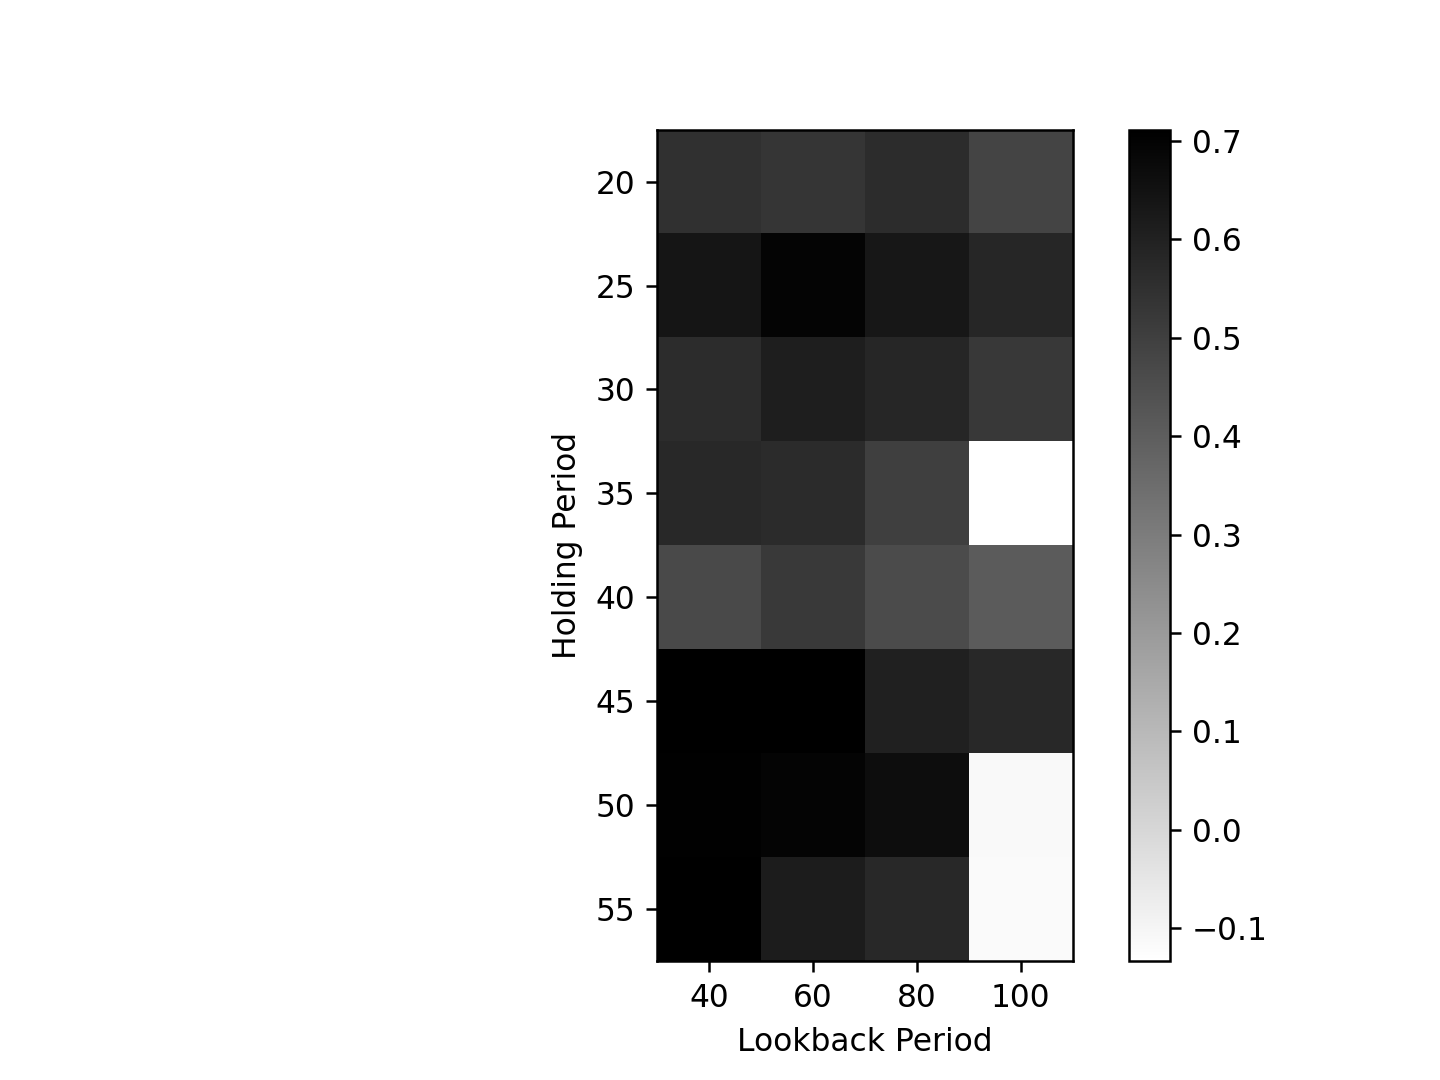

In [49]:
# Heatmap zur Visualiserung
import matplotlib.pyplot as plt
%matplotlib notebook

def heatmap(df, cmap=plt.cm.gray_r):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)
    
heatmap(ddf)   